# Ejemplo de simulación

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pydae.systems.ier.proyecto import proyecto_class
import pydae.grid_tools as gt
%config InlineBackend.figure_format = 'svg'


Primero se instancia el simulador:

In [14]:
pr = proyecto_class()

Los parametros de las líneas y transformadores deben ser adaptados, para ello se puede utilizar la herramienta `change_line` del modulo `pydae.grid_tools`:

In [15]:
gt.change_line(pr,'GR4','GR3',R_km=8.0,X_km=4.0,km=0.5)
gt.change_line(pr,'GR2','GR1',R_km=8.0,X_km=4.0,km=0.5)
gt.change_line(pr,'GR3','PMV',R_km=4.0,X_km=2.0,km=0.5)
gt.change_line(pr,'GR1','PMV',R_km=4.0,X_km=2.0,km=0.5)
gt.change_line(pr,'PMV','POI',R_pu=0.01,X_pu=0.05,S_mva=52.0)
gt.change_line(pr,'POI','GRI',R_km=0.168495,X_km=0.04,km=26)

Una vez que el sistema tiene los parametros deseados se lo puede inicializar.

In [16]:
P_GR = 5e6
Q_GR = 5e6

pr.initialize([{'P_GR1': P_GR, 'Q_GR1': Q_GR,
                'P_GR2': P_GR, 'Q_GR2': Q_GR,
                'P_GR3': P_GR, 'Q_GR3': Q_GR,
                'P_GR4': P_GR, 'Q_GR4': Q_GR}], 1) 

True

Para comprobar que la inicialización fue exitosa se pueden consultar los valores de las variables algebráicas:

In [17]:
pr.report_y()

V_GRI =  0.99
theta_GRI =  0.47
V_POI =  1.04
theta_POI =  0.50
V_PMV =  1.06
theta_PMV =  0.51
V_GR1 =  1.06
theta_GR1 =  0.50
V_GR2 =  1.06
theta_GR2 =  0.50
V_GR3 =  1.06
theta_GR3 =  0.50
V_GR4 =  1.06
theta_GR4 =  0.50
i_d_GRI = -0.07
i_q_GRI = -0.26
P_GRI_1 = -19317132.16
Q_GRI_1 = -18061567.86
v_f_GRI =  0.75
p_m_ref_GRI = -0.19


## Control de tensión del POI

### Control de tensión utilizando sólo el STATCOM

Text(0.5, 0, 'Time (s)')

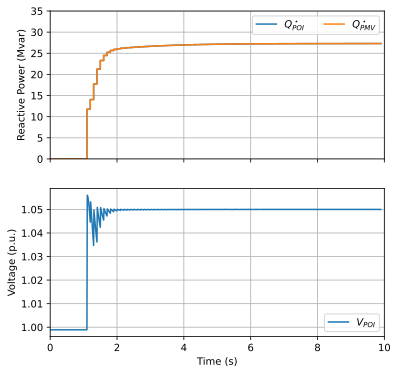

In [36]:
P_GR = 5e6
Q_GR = 0e6

pr.initialize([{'P_GR1': P_GR, 'Q_GR1': Q_GR,
                'P_GR2': P_GR, 'Q_GR2': Q_GR,
                'P_GR3': P_GR, 'Q_GR3': Q_GR,
                'P_GR4': P_GR, 'Q_GR4': Q_GR,
                'P_PMV': 0.0, 'Q_PMV': 0.0}], 1) 

K_g = 1/250e6 # gain of the plant

T_s = 0.1
times = np.arange(0,10,T_s)
N_t = len(times)
N_x = 2

# controller
K_p = -20.0e6
K_i = 1/(T_s*K_g)

# initial conditions
x = 0.0
xi = 0.0
Q_POI_ref = 0.0
V_POI_ref = pr.get_value('V_POI')

X = np.zeros((N_t,N_x))
it = 0
for t in times:
    X[it,0] = xi
    X[it,1] = Q_POI_ref
    
    if t>1.0:
        V_POI_ref = 1.05
        
    # Plant
    pr.set_value('Q_PMV',Q_POI_ref)
    pr.run([{'t_end':t,'Q_PMV':Q_POI_ref}])
    V_POI = pr.get_value('V_POI')
    
    # Controller
    error = V_POI_ref - V_POI
    xi = xi + T_s*error
    Q_POI_ref = K_p*error + K_i*xi
    
    it += 1 

pr.post()
    
plt.close('all')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6),sharex=True)

axes[0].step(times,X[:,1]/1e6,label='$Q_{POI}^\star$')
axes[0].step(times,X[:,1]/1e6,label='$Q_{PMV}^\star$')

axes[1].plot(pr.T,pr.get_values('V_POI'),label='$V_{POI}$')

axes[0].set_ylabel('Reactive Power (Mvar)')
axes[0].set_ylim([0,35])

axes[1].set_ylabel('Voltage (p.u.)')
for ax in axes:
    ax.grid()
    ax.legend(loc='best',ncol=3)
    ax.set_xlim([0,10])

ax.set_xlabel('Time (s)')

### Control de tensión utilizando coordinando generadores y STATCOM

Text(0.5, 0, 'Time (s)')

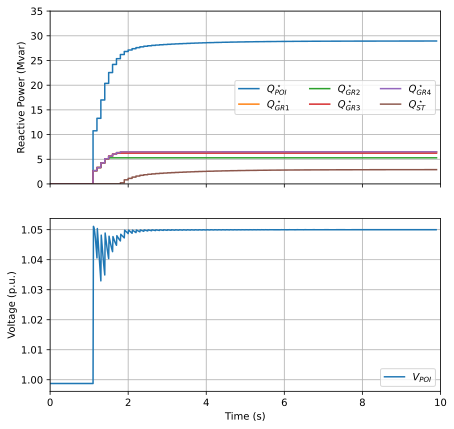

In [34]:
P_GR = 7e6
Q_GR = 0e6
S_GR = 8e6

pr.initialize([{'P_GR1': 4e6, 'Q_GR1': Q_GR,
                'P_GR2': 6e6, 'Q_GR2': Q_GR,
                'P_GR3': 5e6, 'Q_GR3': Q_GR,
                'P_GR4':4.5e6, 'Q_GR4': Q_GR,
                'P_PMV': 0.0, 'Q_PMV': 0.0}], 1) 

K_g = 1/220e6 # gain of the plant

T_s = 0.1
times = np.arange(0,10,T_s)
N_t = len(times)
N_x = 2

# controller
K_p = -1.0e7
K_i = 1/(T_s*K_g)

# initial conditions
x = 0.0
xi = 0.0
Q_POI_ref = 0.0
Q_GR1_ref = 0.0
Q_GR2_ref = 0.0
Q_GR3_ref = 0.0
Q_GR4_ref = 0.0
Q_STATCOM_ref = 0.0
V_POI_ref = pr.get_value('V_POI')
Q_GR_store = np.zeros((N_t,4))
Q_STATCOM_store = np.zeros((N_t,1))
X = np.zeros((N_t,N_x))
it = 0
for t in times:
    X[it,0] = xi
    X[it,1] = Q_POI_ref
    
    if t>1.0:
        V_POI_ref = 1.05
        
    # Plant
    for ig,q in zip(range(1,5),[Q_GR1_ref,Q_GR2_ref,Q_GR3_ref,Q_GR4_ref]):
        P_GR = pr.get_value(f'P_GR{ig}').real
        Q_GR_max = np.sqrt(S_GR**2 - P_GR**2)
        if q> Q_GR_max: q =  Q_GR_max
        if q<-Q_GR_max: q = -Q_GR_max
        pr.set_value(f'Q_GR{ig}',q)   
        Q_GR_store[it,ig-1] = q
        
    pr.run([{'t_end':t,'Q_PMV':Q_STATCOM_ref}])
    Q_STATCOM_store[it,0] = Q_STATCOM_ref
    V_POI = pr.get_value('V_POI')
    
    # Controller
    error = V_POI_ref - V_POI
    xi = xi + T_s*error
    Q_POI_ref = K_p*error + K_i*xi
    p_poi = gt.get_line_s(pr,'POI','GRI').real
    q_gr_max = np.sqrt(S_GR**2 - (p_poi/4)**2)
    Q_GR = Q_POI_ref/4
    if Q_GR> q_gr_max: Q_GR =  q_gr_max
    if Q_GR<-q_gr_max: Q_GR = -q_gr_max
    Q_GR1_ref = Q_GR
    Q_GR2_ref = Q_GR
    Q_GR3_ref = Q_GR
    Q_GR4_ref = Q_GR
    
    Q_STATCOM_ref = Q_POI_ref - 4*Q_GR 
    
    it += 1 

pr.post()
    
plt.close('all')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7),sharex=True)

axes[0].step(times,X[:,1]/1e6,label='$Q_{POI}^\star$')
for ig in range(4):
    axes[0].step(times,Q_GR_store[:,ig]/1e6,label=f'$Q_{{GR{ig+1}}}^\star$')
axes[0].step(times,Q_STATCOM_store[:,0]/1e6,label='$Q_{ST}^\star$')
axes[1].plot(pr.T,pr.get_values('V_POI'),label='$V_{POI}$')

axes[0].set_ylabel('Reactive Power (Mvar)')
axes[0].set_ylim([0,35])

axes[1].set_ylabel('Voltage (p.u.)')
for ax in axes:
    ax.grid()
    ax.legend(loc='best',ncol=3)
    ax.set_xlim([0,10])

ax.set_xlabel('Time (s)')